In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)


True True


In [7]:
PATH = "data/digit/"

In [8]:
train_df = pd.read_csv(f"{PATH}train.csv")
test_df = pd.read_csv(f"{PATH}test.csv")

In [9]:
train_df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print(train_df.shape, test_df.shape)


(42000, 785) (28000, 784)


In [11]:
# create validation dataset
val_df = train_df.sample(frac=0.2, random_state=1337)
val_df.shape

(8400, 785)

In [12]:
# remove validation data from train dataset
train_df = train_df.drop(val_df.index)
train_df.shape


(33600, 785)

In [13]:
# separate labels from data
Y_train = train_df["label"]
Y_valid = val_df["label"]
X_train = train_df.drop("label", axis=1)
X_valid = val_df.drop("label", axis=1)

In [14]:
print(X_train.shape, X_valid.shape)
print(Y_train.shape, Y_valid.shape)

(33600, 784) (8400, 784)
(33600,) (8400,)


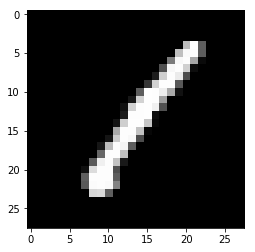

In [15]:
img = X_train.iloc[0,:].values.reshape(28,28)
plt.imshow(img, cmap="gray")


In [16]:
def reshape_img(matrix):
    """
    Reshape an existing 2D pandas.dataframe into 3D-numpy.ndarray
    """
    try:
        return matrix.values.reshape(-1, 28, 28)
    except AttributeError as e:
        print(e)

In [17]:
def add_color_channel(matrix):
    """
    Add missing color channels to previously reshaped image
    """
    matrix = np.stack((matrix, ) *3, axis = -1)
    return matrix

In [18]:
def convert_ndarry(matrix):
    """
    Convert pandas.series into numpy.ndarray
    """
    try:
        return matrix.values.flatten()
    except AttributeError as e:
        print(e)


In [19]:
# reshape data and add color channels
X_train = reshape_img(X_train)
X_train = add_color_channel(X_train)
X_valid = reshape_img(X_valid)
X_valid = add_color_channel(X_valid)
test_df = reshape_img(test_df)
test_df = add_color_channel(test_df)

In [20]:
# convert y_train and y_valid into proper numpy.ndarray
Y_train = convert_ndarry(Y_train)
Y_valid = convert_ndarry(Y_valid)

In [21]:
# run sanity checks
preprocessed_data = [X_train, Y_train, X_valid, Y_valid, test_df]
print([e.shape for e in preprocessed_data])
print([type(e) for e in preprocessed_data])

[(33600, 28, 28, 3), (33600,), (8400, 28, 28, 3), (8400,), (28000, 28, 28, 3)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [22]:
# define architecture
arch = resnet50
sz = 28
classes = np.unique(Y_train)


In [23]:
data = ImageClassifierData.from_arrays(path=PATH, 
                                       trn=(X_train, Y_train),
                                       val=(X_valid, Y_valid),
                                       classes=Y_train,
                                       test=test_df,
                                       tfms=tfms_from_model(arch, sz))

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/mayjain/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:09<00:00, 10793310.82it/s]


100%|██████████| 438/438 [00:10<00:00, 40.78it/s]


In [25]:
lrf = learn.lr_find()


 84%|████████▎ | 439/525 [00:05<00:01, 65.12it/s, loss=3.12] 


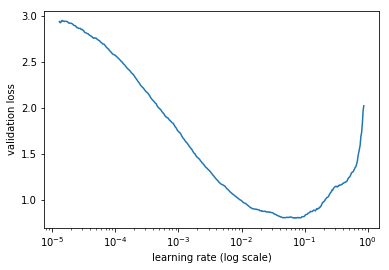

In [26]:
learn.sched.plot()


In [27]:
learn.fit(1e-2, 2)


epoch      trn_loss   val_loss   accuracy                     
    0      0.404309   0.382639   0.908095  
    1      0.375707   0.34837    0.919524                     



[array([0.34837]), 0.9195238095238095]

In [28]:
# disable precompute and unfreeze layers
learn.precompute=False
learn.unfreeze()

In [29]:
lr = np.array([0.001, 0.0075, 0.01])


In [30]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                     
    0      0.067051   0.038621   0.987619  
    1      0.044626   0.026413   0.991905                     
    2      0.031182   0.025783   0.991548                     
    3      0.037255   0.033      0.990357                     
    4      0.019725   0.025278   0.992024                     
    5      0.009926   0.024269   0.993333                      
    6      0.009911   0.022556   0.993214                      

CPU times: user 3min 52s, sys: 47.6 s, total: 4min 40s
Wall time: 4min 11s


[array([0.02256]), 0.9932142857142857]

In [31]:
# get accuracy for validation set
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9932142857142857

In [32]:
# predict on test set
%time log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
probs_test.shape

CPU times: user 48.1 s, sys: 8.01 s, total: 56.1 s
Wall time: 45 s


(28000, 10)

In [33]:
# create dataframe from probabilities
df = pd.DataFrame(probs_test)


In [34]:
# increase index by 1 to obtain proper ImageIDs
df.index += 1

In [35]:
# create new colum containing label with highest probability for each digit
df = df.assign(Label = df.values.argmax(axis=1))

In [36]:
# replicate index as dedicated ImageID column necessary for submission
df = df.assign(ImageId = df.index.values)

In [37]:
# drop individual probabilites
df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)

In [38]:
# reorder columns for submission
df = df[["ImageId", "Label"]]

In [39]:
# run sanity checks
df.head()

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3


In [40]:
df.shape

(28000, 2)

In [41]:
df.to_csv(f"{PATH}submission_digit.csv", index=False)


In [42]:
from IPython.display import FileLink, FileLinks


In [43]:
FileLink(f"{PATH}submission_digit.csv")

/home/mayjain/fastai/courses/dl1/data/digit/submission_digit.csv